# Arewa Data Science Academy
### Deep Learning Cohort2.0
### Name: Ahmad Wafiq Saad
### Title: Week 4 Solution

### Exercises Solution

### 1. Computer Vision in Industry

Autonomous Vehicles: Object detection, lane detection, and traffic sign recognition are crucial for self-driving cars.
Medical Imaging: Analyzing X-rays, MRIs, and CT scans to detect abnormalities and assist in diagnosis.
Manufacturing: Quality control, defect detection, and robotic assembly using image analysis.
### 2. Overfitting in Machine Learning

Overfitting occurs when a model learns the training data too well, including its noise and outliers, leading to poor performance on unseen data.   
### 3. Ways to Prevent Overfitting

Data Augmentation: Creating variations of the training data (e.g., rotations, flips) to increase its diversity and expose the model to more scenarios. This helps the model generalize better.
Regularization: Adding a penalty term to the loss function to discourage overly complex models. L1 and L2 regularization are common techniques.
Dropout: Randomly deactivating neurons during training to prevent them from co-adapting and relying too heavily on each other. This reduces the model's sensitivity to specific features.

### 4. Activity exercise

### 5. Load MNIST Datasets

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms

transform = transforms.ToTensor()  # Convert images to tensors

train_data = datasets.MNIST(root="data", train=True, transform=transform, download=True)
test_data = datasets.MNIST(root="data", train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### 6. Visualize MNIST Samples

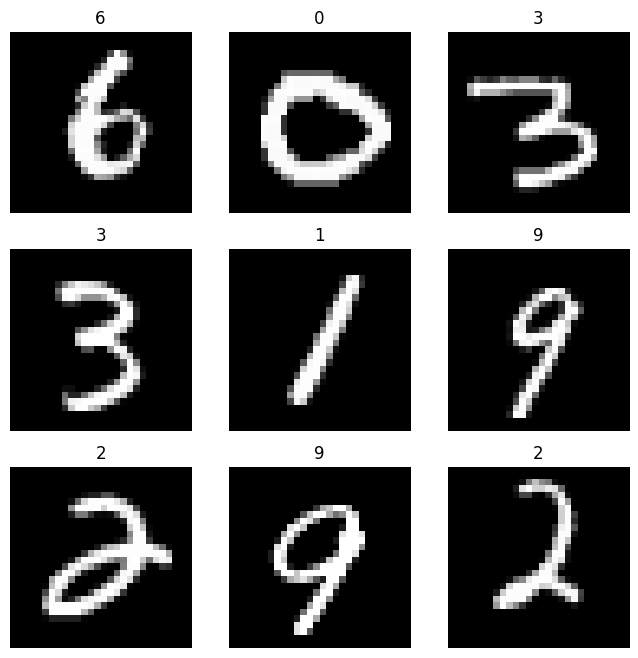

In [2]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 7. Create MNIST Dataloaders

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

### 8. Recreate TinyVGG (Model 2)

In [4]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

model_2 = TinyVGG(input_shape=1, hidden_units=10, output_shape=len(train_data.classes))

### 9. Train Model on CPU and GPU

In [6]:
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
model_2.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum()  # Sum of correct predictions as a tensor
    acc = (correct.float() / len(y_pred)) * 100 #calculate accuracy as a tensor
    return acc

def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred_class).item()
    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    return train_loss, train_acc

start_time_cpu = time.perf_counter()
#train on cpu
for epoch in range(3):
    train_loss, train_acc = train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, "cpu")
end_time_cpu = time.perf_counter()
print(f"cpu training time: {end_time_cpu-start_time_cpu}")

start_time_gpu = time.perf_counter()
#train on gpu
for epoch in range(3):
    train_loss, train_acc = train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
end_time_gpu = time.perf_counter()
print(f"gpu training time: {end_time_gpu-start_time_gpu}")

cpu training time: 82.69765445600001
gpu training time: 78.44679934300007


### 10. Make Predictions and Visualize

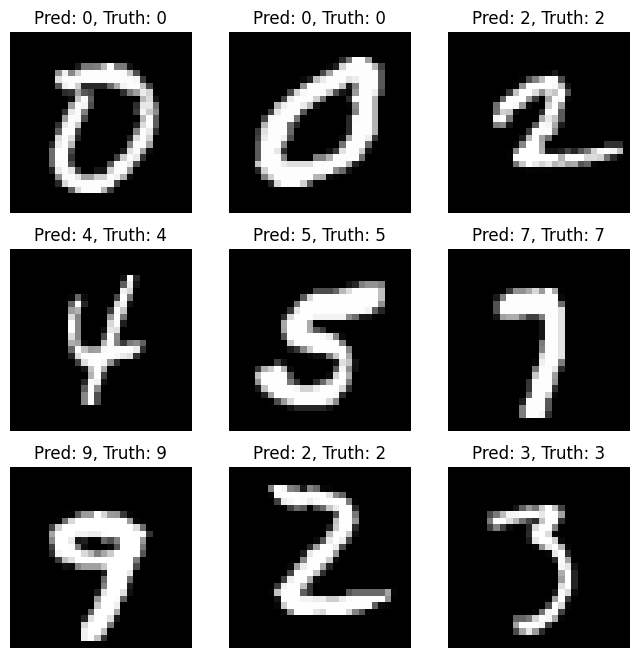

In [7]:
model_2.eval()
with torch.inference_mode():
    test_preds = model_2(test_data.data.unsqueeze(dim=1).type(torch.float32).to(device))
    test_preds_labels = test_preds.argmax(dim=1)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    pred_label = test_preds_labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {pred_label}, Truth: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 11. Confusion Matrix

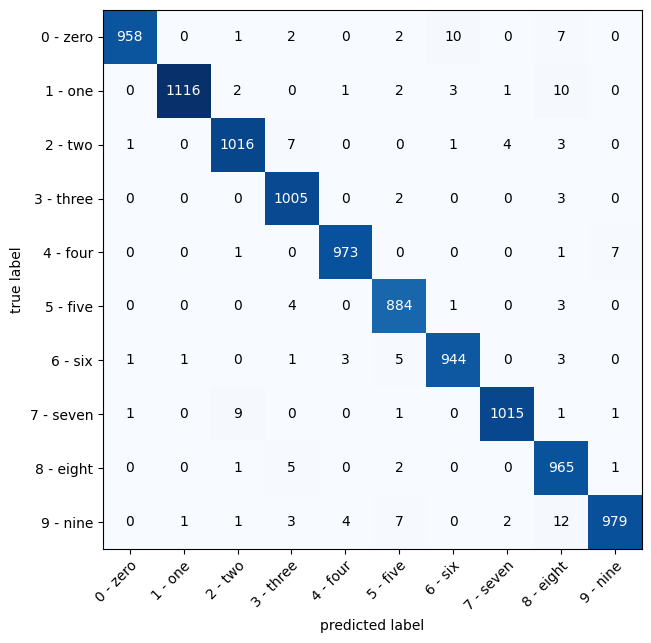

In [10]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=10, task='multiclass')
confmat_tensor = confmat(preds=test_preds_labels.cpu(), target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=test_data.classes, figsize=(10, 7))